# Visualizing Decision Boundaries

In this notebook, we visualize the decision boundaries of the link classifier based on [this scikit-learn example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

100%|██████████| 542/542 [00:00<00:00, 619431.27it/s]


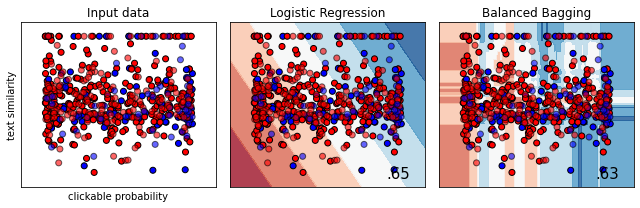

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
import json
from tqdm import tqdm

h = 0.02  # step size in the mesh

names = [
    "Logistic Regression",
    "Balanced Bagging",
]

classifiers = [
    SGDClassifier(loss="log", class_weight="balanced"),
    BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2,
    )
]

def make_links():
    training_data_path = "../Screen2Vec/simplifiedscreen2vec/data/links.json"
    with open(training_data_path) as training_data_json:
        initial_training_data = json.load(training_data_json)["links"]

    X = []
    Y = []
    for data_point in tqdm(initial_training_data):
        is_link = data_point["isLink"]
        source_is_clickable_probability = data_point["link"][
            "sourceClickableProbability"
        ]
        source_target_text_similarity = data_point["link"]["sourceTargetTextSimilarity"]
        X.append(
            [source_is_clickable_probability]
            + [source_target_text_similarity]
        )
        Y.append(int(is_link))
    return np.array(X), np.array(Y)

datasets = [
    make_links(),
]

figure = plt.figure(figsize=(9, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("clickable probability")
    ax.set_ylabel("text similarity")
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd

links_data_path = "../Screen2Vec/simplifiedscreen2vec/data/links.json"
with open(links_data_path) as links_data_json:
    links = json.load(links_data_json)["links"]

links_df = pd.DataFrame(pd.json_normalize(links))
links_df.head()

,isLink,link.sourceClickableProbability,link.sourceTargetTextSimilarity
0,False,0.964670,0.411724
1,True,0.792333,0.511169
2,False,0.833955,0.511169
3,True,0.046383,0.511169
4,False,0.559973,0.511169


In [11]:
links_df.describe()

,link.sourceClickableProbability,link.sourceTargetTextSimilarity
count,542.000000,542.000000
mean,0.475518,0.549415
std,0.327418,0.208538
min,0.000351,0.012934
25%,0.187625,0.413995
50%,0.446672,0.512058
75%,0.778906,0.641750
max,0.999453,1.000000


In [12]:
links_df.groupby("isLink").describe()

link.sourceClickableProbability                                \
                                 count      mean       std       min   
isLink                                                                 
False                            410.0  0.433414  0.317743  0.000351   
True                             132.0  0.606294  0.323618  0.010127   

                                                \
             25%       50%       75%       max   
isLink                                           
False   0.150232  0.395057  0.722940  0.993894   
True    0.335050  0.665454  0.932268  0.999453   

       link.sourceTargetTextSimilarity                                \
                                 count      mean       std       min   
isLink                                                                 
False                            410.0  0.549207  0.200882  0.012934   
True                             132.0  0.550062  0.231531  0.028609   

                                           
             25%       50%       75%  max  
isLink                                     
False   0.416746  0.523301  0.641077  1.0  
True    0.409283  0.491088  0.671082  1.0

In [13]:
rough_total_sample_size = 100
sample = links_df.groupby('isLink').apply(lambda link_class: link_class.sample(int(rough_total_sample_size/2))).reset_index(drop=True)
sample.head()

,isLink,link.sourceClickableProbability,link.sourceTargetTextSimilarity
0,False,0.015897,0.497171
1,False,0.054390,0.620166
2,False,0.707714,0.686902
3,False,0.197887,0.329254
4,False,0.097943,0.388471


In [14]:
sample.describe()

,link.sourceClickableProbability,link.sourceTargetTextSimilarity
count,100.000000,100.000000
mean,0.489581,0.536198
std,0.347703,0.207161
min,0.001349,0.060971
25%,0.123532,0.414635
50%,0.472142,0.492795
75%,0.817390,0.623939
max,0.999367,1.000000


In [15]:
sample.groupby("isLink").describe()

link.sourceClickableProbability                                \
                                 count      mean       std       min   
isLink                                                                 
False                             50.0  0.396245  0.336625  0.001349   
True                              50.0  0.582916  0.336405  0.017738   

                                                \
             25%       50%       75%       max   
isLink                                           
False   0.067327  0.377709  0.636445  0.993894   
True    0.291750  0.653491  0.919178  0.999367   

       link.sourceTargetTextSimilarity                                \
                                 count      mean       std       min   
isLink                                                                 
False                             50.0  0.499688  0.175851  0.102415   
True                              50.0  0.572707  0.230354  0.060971   

                                           
             25%       50%       75%  max  
isLink                                     
False   0.413726  0.467571  0.548870  1.0  
True    0.422241  0.501356  0.698829  1.0

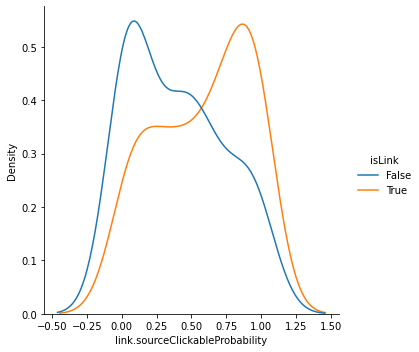

In [17]:
import seaborn as sns

sns.displot(data=sample, x="link.sourceClickableProbability", hue="isLink", kind="kde")

<AxesSubplot:xlabel='isLink', ylabel='link.sourceClickableProbability'>

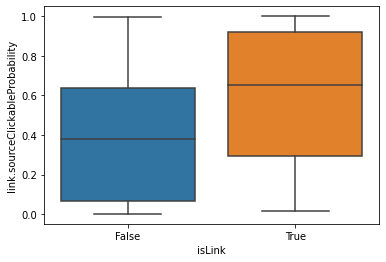

In [26]:
sns.boxplot(data=sample, x="isLink", y="link.sourceClickableProbability")

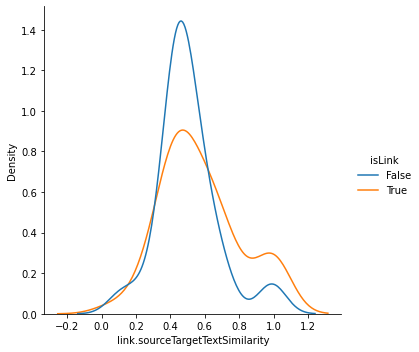

In [18]:
sns.displot(data=sample, x="link.sourceTargetTextSimilarity", hue="isLink", kind="kde")

<AxesSubplot:xlabel='isLink', ylabel='link.sourceTargetTextSimilarity'>

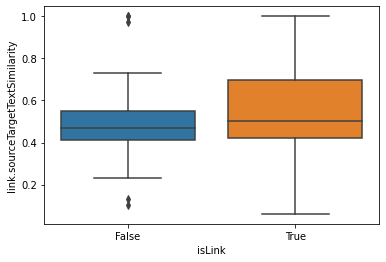

In [22]:
sns.boxplot(data=sample, x="isLink", y="link.sourceTargetTextSimilarity")